Text provided under a Creative Commons Attribution license, CC-BY.  All code is made available under the FSF-approved MIT license.  (c) Lorena A. Barba, Gilbert F. Forsyth 2015. Thanks to NSF for support via CAREER award #1149784.

[@LorenaABarba](https://twitter.com/LorenaABarba)

##### Version 0.12 (August 2015)

12 steps to Navier-Stokes
======
***

Hello! Welcome to the **12 steps to Navier-Stokes**. This is a practical module that is used in the beginning of an interactive Computational Fluid Dynamics (CFD) course taught by [Prof. Lorena Barba](http://lorenabarba.com) since Spring 2009 at Boston University. The course assumes only basic programming knowledge (in any language) and of course some foundation in partial differential equations and fluid mechanics. The practical module was inspired by the ideas of Dr. Rio Yokota, who was a post-doc in Barba's lab, and has been refined by Prof. Barba and her students over several semesters teaching the course. The course is taught entirely using Python and students who don't know Python just learn as we work through the module.

This [IPython notebook](http://ipython.org/ipython-doc/stable/interactive/htmlnotebook.html) will lead you through the first step of programming your own Navier-Stokes solver in Python from the ground up.  We're going to dive right in.  Don't worry if you don't understand everything that's happening at first, we'll cover it in detail as we move forward and you can support your learning with the videos of [Prof. Barba's lectures on YouTube](http://www.youtube.com/playlist?list=PL30F4C5ABCE62CB61).

For best results, after you follow this notebook, prepare your own code for Step 1, either as a Python script or in a clean IPython notebook.

To execute this Notebook, we assume you have invoked the notebook server using: `ipython notebook`.

Step 1: 1-D Linear Convection
-----
***

The 1-D Linear Convection equation is the simplest, most basic model that can be used to learn something about CFD. It is surprising that this little equation can teach us so much! Here it is:

$$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0$$

With given initial conditions (understood as a *wave*), the equation represents the propagation of that initial *wave* with speed $c$, without change of shape. Let the initial condition be $u(x,0)=u_0(x)$. Then the exact solution of the equation is $u(x,t)=u_0(x-ct)$.

We discretize this equation in both space and time, using the Forward Difference scheme for the time derivative and the Backward Difference scheme for the space derivative. Consider discretizing the spatial coordinate $x$ into points that we index from $i=0$ to $N$, and stepping in discrete time intervals of size $\Delta t$.

From the definition of a derivative (and simply removing the limit), we know that:

$$\frac{\partial u}{\partial x}\approx \frac{u(x+\Delta x)-u(x)}{\Delta x}$$

Our discrete equation, then, is:

$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + c \frac{u_i^n - u_{i-1}^n}{\Delta x} = 0 $$

Where $n$ and $n+1$ are two consecutive steps in time, while $i-1$ and $i$ are two neighboring points of the discretized $x$ coordinate. If there are given initial conditions, then the only unknown in this discretization is $u_i^{n+1}$.  We can solve for our unknown to get an equation that allows us to advance in time, as follows:

$$u_i^{n+1} = u_i^n - c \frac{\Delta t}{\Delta x}(u_i^n-u_{i-1}^n)$$

Now let's try implementing this in Python.  

We'll start by importing a few libraries to help us out.

* `numpy` is a library that provides a bunch of useful matrix operations akin to MATLAB
* `matplotlib` is a 2D plotting library that we will use to plot our results
* `time` and `sys` provide basic timing functions that we'll use to slow down animations for viewing

In [1]:
# Remember: comments in python are denoted by the pound sign
import numpy                       #here we load numpy
from matplotlib import pyplot      #here we load matplotlib
import time, sys                   #and load some utilities


In [2]:
#this makes matplotlib plots appear in the notebook (instead of a separate window)
%matplotlib inline                  

Now let's define a few variables; we want to define an evenly spaced grid of points within a spatial domain that is 2 units of length wide, i.e., $x_i\in(0,2)$.  We'll define a variable `nx`, which will be the number of grid points we want and `dx` will be the distance between any pair of adjacent grid points.  

In [3]:
nx = 41  # try changing this number from 41 to 81 and Run All ... what happens?
dx = 2 / (nx-1)
nt = 25    #nt is the number of timesteps we want to calculate
dt = .025  #dt is the amount of time each timestep covers (delta t)
c = 1      #assume wavespeed of c = 1

We also need to set up our initial conditions. The initial velocity $u_0$ is given as 
$u = 2$ in the interval $0.5 \leq x \leq 1$  and $u = 1$ everywhere else in $(0,2)$ (i.e., a hat function).

Here, we use the function `ones()` defining a `numpy` array which is `nx` elements long with every value equal to 1.

In [4]:
u = numpy.ones(nx)      #numpy function ones()
u[int(.5 / dx):int(1 / dx + 1)] = 2  #setting u = 2 between 0.5 and 1 as per our I.C.s
print(u)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.]


Now let's take a look at those initial conditions using a Matplotlib plot.  We've imported the `matplotlib` plotting library `pyplot` and the plotting function is called `plot`, so we'll call `pyplot.plot`. To learn about the myriad possibilities of Matplotlib, explore the [Gallery](http://matplotlib.org/gallery.html) of example plots.

Here, we use the syntax for a simple 2D plot: `plot(x,y)`, where the `x` values are evenly distributed grid points:

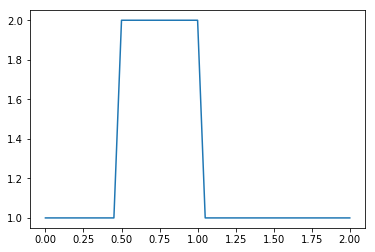

In [5]:
pyplot.plot(numpy.linspace(0, 2, nx), u);

Why doesn't the hat function have perfectly straight sides? Think for a bit.

Now it's time to implement the discretization of the convection equation using a finite-difference scheme.  

For every element of our array `u`, we need to perform the operation $u_i^{n+1} = u_i^n - c \frac{\Delta t}{\Delta x}(u_i^n-u_{i-1}^n)$

We'll store the result in a new (temporary) array `un`, which will be the solution $u$ for the next time-step.  We will repeat this operation for as many time-steps as we specify and then we can see how far the wave has convected.  

We first initialize our placeholder array `un` to hold the values we calculate for the $n+1$ timestep, using once again the NumPy function `ones()`.

Then, we may think we have two iterative operations: one in space and one in time (we'll learn differently later), so we'll start by nesting one loop inside the other. Note the use of the nifty `range()` function. When we write: `for i in range(1,nx)` we will iterate through the `u` array, but we'll be skipping the first element (the zero-th element).  *Why?*

In [6]:
un = numpy.ones(nx) #initialize a temporary array

for n in range(nt):  #loop for values of n from 0 to nt, so it will run nt times
    un = u.copy() ##copy the existing values of u into un
    for i in range(1, nx): ## you can try commenting this line and...
    #for i in range(nx): ## ... uncommenting this line and see what happens!
        u[i] = un[i] - c * dt / dx * (un[i] - un[i-1])
        
        

**Note**—We will learn later that the code as written above is quite inefficient, and there are better ways to write this, Python-style. But let's carry on.

Now let's try plotting our `u` array after advancing in time.

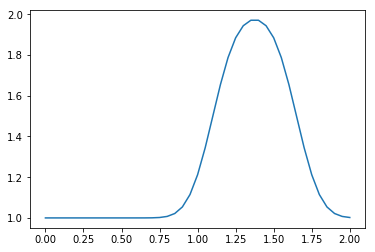

In [7]:
pyplot.plot(numpy.linspace(0, 2, nx), u);

OK! So our hat function has definitely moved to the right, but it's no longer a hat.  **What's going on?**

Learn More
-----
***

For a more thorough explanation of the finite-difference method, including topics like the truncation error, order of convergence and other details, watch **Video Lessons 2 and 3** by Prof. Barba on YouTube.

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('iz22_37mMkk')

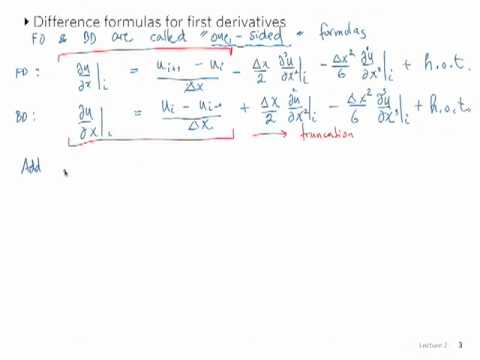

In [9]:
YouTubeVideo('xq9YTcv-fQg')

For a careful walk-through of the discretization of the linear convection equation with finite differences (and also the following steps, up to Step 4), watch **Video Lesson 4** by Prof. Barba on YouTube.

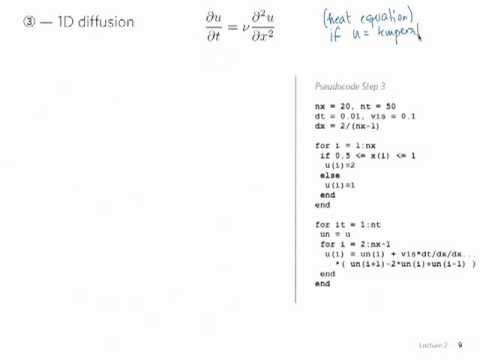

In [10]:
YouTubeVideo('y2WaK7_iMRI')

## Last but not least

**Remember** to rewrite Step 1 as a fresh Python script or in *your own* IPython notebook and then experiment by changing the discretization parameters. Once you have done this, you will be ready for [Step 2](./02_Step_2.ipynb).


***

In [11]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

> (The cell above executes the style for this notebook. We modified a style we found on the GitHub of [CamDavidsonPilon](https://github.com/CamDavidsonPilon), [@Cmrn_DP](https://twitter.com/cmrn_dp).)